In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib
font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'weight' : 'normal',
        'size'   : 7}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('font', **font)

In [2]:
def draw_pie( dist, 
             xpos, 
             ypos, 
             size, 
             colors,  
             ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for r1, r2, c in zip(pie[:-1], pie[1:], colors):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        sc = ax.scatter([xpos], [ypos], marker=xy, s=size, zorder = 2, edgecolors='black',linewidth = 0.5, color = c)
        #ax.legend(*sc.legend_elements("sizes", num=6))
    return ax

In [3]:
centroids = pd.read_csv("../Data/country_centroids.txt", \
                        sep = '\t', index_col=0)


colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']
data = pd.read_csv('../Data/map_data_preprint.txt', \
           header = 0, index_col = 0, sep = '\t', usecols = range(0,19))
data.replace(to_replace=0.0, value=1, inplace = True)
data.replace(to_replace="England", value="United Kingdom", inplace = True)

data['bins'] = pd.cut(x=data['Plot Mid'], include_lowest = True, right = False, bins=[-6000, -5000, -4000, -3000, -2000, \
                                                -1000,1,  1000, 2000])

data['Left'] = data['bins'].apply(lambda x: x.left)

col = {}
for color, boundary in zip(colors, sorted(list(set(data.Left)))): 
    col[boundary] = color

colors = [col[boundary] for boundary in list(data.Left)]

reformat_data = []
for country in data.Country.unique():
    sub = data[data.Country == country]
    lefts = list(sub.Left)
    count = []
    c = []
    for boundary, color in zip([-6000, -5000, -4000, -3000, -2000, -1000, 1, 1000, 'Unknown'], ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255', '#808080']):
        if lefts.count(boundary) != 0: 
            count.append(lefts.count(boundary))
            c.append(color)
    latitude = centroids.loc[country, 'latitude']
    longitude = centroids.loc[country, 'longitude']
    reformat_data.append([country,sum(count), count, c, latitude, longitude])   
    

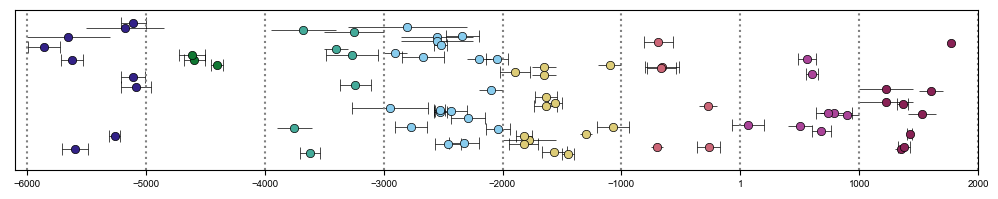

In [4]:
fig, ax = plt.subplots(figsize=(10, 2))

for index, row in data.iterrows(): 
    jitter = random.randint(0,100) * random.choice([-.01,.01])
    error = row['Plot To'] - row['Plot Mid']
    if row['C14 Dated?'] == 'Yes':
        ax.errorbar(row['Plot Mid'] , jitter, xerr= error, capsize = 4 , ls = 'none', \
                c = col[row.Left], markersize = 6, fmt= 'o', mec = 'black', markeredgewidth = 0.5, elinewidth=0.5, ecolor = 'black')
    elif row['C14 Dated?'] == 'No': 
        ax.errorbar(row['Plot Mid'] , jitter, xerr= error, capsize = 0 , ls = 'none', \
                c = col[row.Left], markersize = 6, fmt= 'o', mec = 'black', markeredgewidth = 0.5, elinewidth=0.5, ecolor = 'black')

ax.set_xticks([-6000, -5000, -4000, -3000, -2000, -1000, 1, 1000, 2000])
ax.set_yticks([])
ax.set_xlim([-6100, 2000])
ax.set_ylim([-1.2, 1.2])

for x in [-6000, -5000, -4000, -3000, -2000, -1000, 1, 1000, 2000]:
    ax.axvline(x=x, color='black', linestyle=':', c='gray')
fig.tight_layout()
plt.savefig('./fig1_timeline_preprint.pdf', format = 'pdf', dpi = 300)


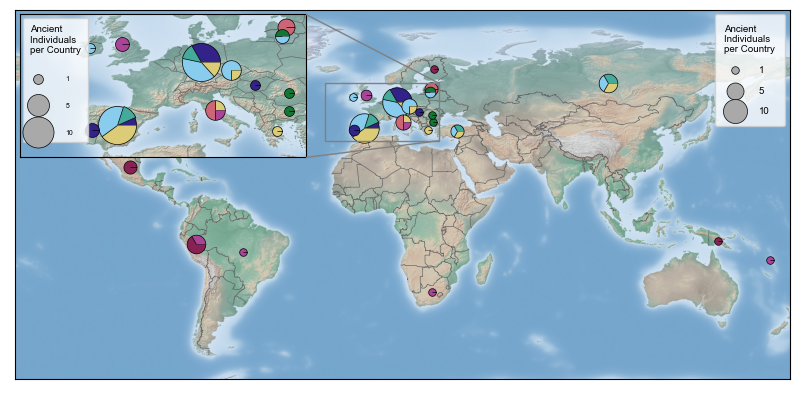

In [5]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

# setup Cylindrical basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(projection='cyl', llcrnrlon=-150.,llcrnrlat=-65.,urcrnrlon=175.,urcrnrlat=90., resolution = 'h')
m.shadedrelief(zorder = 0)
m.drawcountries(linewidth=0.5, linestyle='solid', color='dimgray', zorder = 1)

l1 = plt.scatter([],[], s=1 * 30, edgecolors='black', color = 'darkgray', linewidth = 0.5,)
l2 = plt.scatter([],[], s=5 * 30, edgecolors='black', color = 'darkgray', linewidth = 0.5,)
l3 = plt.scatter([],[], s=10 * 30, edgecolors='black', color = 'darkgray', linewidth = 0.5,)
l4 = plt.scatter([],[], s=15 * 30, edgecolors='black', color = 'darkgray', linewidth = 0.5,)

labels = ["1", "5", "10", "15"]

leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=7,
handlelength=1, loc = 1, borderpad = 1,
handletextpad=2, title='Ancient \nIndividuals \nper Country', scatterpoints = 1, labelspacing = 1.2)

    
    
# # add scatter points to map
for country in reformat_data: 
    draw_pie(country[2], country[5], country[4], 30 * country[1], country[3], ax=ax, )
    
# lons, lats = m(data['Longitude'],data['Latitude'])
# m.scatter(lons, lats, marker = 'o', color=colors, edgecolors='black',\
#           linewidth = 0.5, s = 30)

# add inset locator
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.set_xlim(30, 60)
axins.set_ylim(-15, 30)

# turn of tick labels
plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=-20,llcrnrlat=35,urcrnrlon=28,urcrnrlat=59, ax=axins)
map2.shadedrelief(zorder = 0)
map2.drawcountries(linewidth=0.5, linestyle='solid', color='dimgray', zorder = 1)

# # add scatter points to map
for country in reformat_data: 
    draw_pie(country[2], country[5], country[4], 50 * country[1], country[3], ax=map2 )
    
l1 = plt.scatter([],[], s=1 * 50, edgecolors='black', color = 'darkgray', linewidth = 0.5,)
l2 = plt.scatter([],[], s=5 * 50, edgecolors='black', color = 'darkgray', linewidth = 0.5,)
l3 = plt.scatter([],[], s=10 * 50, edgecolors='black', color = 'darkgray', linewidth = 0.5,)
l4 = plt.scatter([],[], s=15 * 50, edgecolors='black', color = 'darkgray', linewidth = 0.5,)

labels = ["1", "5", "10", "15"]

leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=5,
handlelength=0, loc = 2, borderpad = 1,
handletextpad=4, title='Ancient \nIndividuals \nper Country', scatterpoints = 1, labelspacing = 3)

mark_inset(ax, axins, loc1=1, loc2=4, ec="0.5", zorder = 4)

plt.savefig('./fig1_map_preprint.pdf', format = 'pdf', dpi = 300)